<a href="https://colab.research.google.com/github/ondhokaar/Strip-AI/blob/main/strip_ai_colab_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
 tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
len(gpus)

1

In [5]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import cv2
import imghdr
from matplotlib import pyplot as plt

## *Setup kaggle API*

---



In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/

In [9]:
!kaggle datasets download -d khivnguyn/mayo-competition-dataset

 99% 24.0M/24.2M [00:01<00:00, 27.0MB/s]
100% 24.2M/24.2M [00:01<00:00, 17.7MB/s]


In [10]:
!unzip /content/mayo-competition-dataset.zip

Archive:  /content/mayo-competition-dataset.zip
  inflating: Mayo_Competition/test_224/006388_0.jpg  
  inflating: Mayo_Competition/test_224/008e5c_0.jpg  
  inflating: Mayo_Competition/test_224/00c058_0.jpg  
  inflating: Mayo_Competition/test_224/01adc5_0.jpg  
  inflating: Mayo_Competition/train_224/006388_0.jpg  
  inflating: Mayo_Competition/train_224/008e5c_0.jpg  
  inflating: Mayo_Competition/train_224/00c058_0.jpg  
  inflating: Mayo_Competition/train_224/01adc5_0.jpg  
  inflating: Mayo_Competition/train_224/026c97_0.jpg  
  inflating: Mayo_Competition/train_224/028989_0.jpg  
  inflating: Mayo_Competition/train_224/029c68_0.jpg  
  inflating: Mayo_Competition/train_224/032f10_0.jpg  
  inflating: Mayo_Competition/train_224/0372b0_0.jpg  
  inflating: Mayo_Competition/train_224/037300_0.jpg  
  inflating: Mayo_Competition/train_224/03d1ec_0.jpg  
  inflating: Mayo_Competition/train_224/03e6b7_0.jpg  
  inflating: Mayo_Competition/train_224/0415c3_0.jpg  
  inflating: Mayo_Com


done setup

---





In [12]:
os.listdir('./')

['.config',
 'Mayo_Competition',
 'Mayo_Competition_V2',
 'kaggle.json',
 'mayo-competition-dataset.zip',
 'sample_data']

# Let's see what type of images do we have

In [13]:
s = set()
for img_class in os.listdir('./Mayo_Competition'):
  for image in os.listdir(os.path.join('./Mayo_Competition', img_class)):
    image_path = os.path.join('./Mayo_Competition', img_class, image)
    try:
      img = cv2.imread(image_path)
      tip = imghdr.what(image_path)
      s.add(tip)
    except Exception:
      pass
print(s)

{'jpeg'}


so, we have only `jpeg` images. 

## Reading `jpeg` using `cv2`

In [14]:
img = cv2.imread('/content/Mayo_Competition/train_224/d346ca_0.jpg')
img.shape

(224, 224, 3)

## Ploting `cv2.imread()` object using `matplotlib`

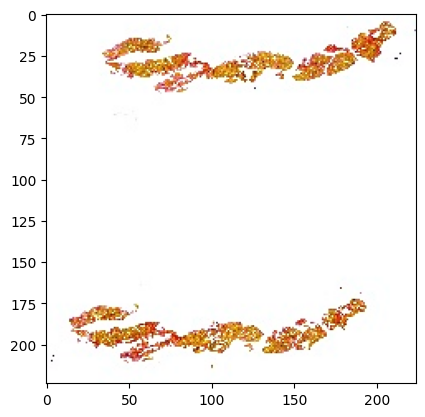

In [15]:
plt.imshow(img)

BGR to RGB

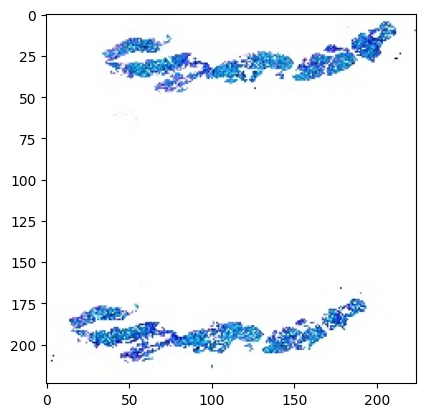

In [ ]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# ***Exploring the dataset***

---





In [17]:
df = pd.read_csv('./Mayo_Competition_V2/train.csv')
df.head(10)

,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE
2,00c058_0,11,00c058,0,LAA
3,01adc5_0,11,01adc5,0,LAA
4,026c97_0,4,026c97,0,CE
5,028989_0,5,028989,0,LAA
6,029c68_0,5,029c68,0,CE
7,032f10_0,7,032f10,0,CE
8,0372b0_0,7,0372b0,0,CE
9,037300_0,11,037300,0,CE


In [18]:
df.shape

(957, 5)


---

# ***LOADING DATA*** *using* `Tensorflow`



---



In [19]:
data = tf.keras.utils.image_dataset_from_directory('./Mayo_Competition', batch_size = 64, image_size=(224, 224))
it = data.as_numpy_iterator()

Found 756 files belonging to 2 classes.


# *Scaling Data*
*each pixel value was initially within 0 to 255<br>
we will scale it to 0 to 1*

In [20]:
sc_data = data.map(lambda x, y: (x/255, y))
sc_it = sc_data.as_numpy_iterator()

In [21]:
batch = sc_it.next()


In [22]:
len(sc_data)

12

## *Dividing into training, testing & validating dataset*

In [23]:
train_size = int(len(sc_data) * 0.7)
test_size = int(len(sc_data)*.1)+1
val_size  = int(len(sc_data)*.2)
train_size + test_size + val_size

12

In [24]:
train = sc_data.take(train_size)
val = sc_data.skip(train_size).take(val_size)
test = sc_data.skip(train_size+val_size).take(test_size)

# *Model Creation begins here*

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout